# Optimize a dense network with Bayesian optimization
Authors: Thong Nguyen

In [1]:
!fusermount -u drive

fusermount: failed to unmount /content/drive: No such file or directory


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'machine-learning-vbscan/'

Mounted at /content/gdrive


## Usual setup: Loading `pandas` DataFrames, creating training and testing dataset


In [0]:
import uproot
import numpy as np
import pandas as pd
import h5py
import torch
import torch.nn as nn

import time

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

treename = 'HZZ4LeptonsAnalysisReduced'
filename = {}
upfile = {}
params = {}
df = {}

filename['VV'] = base_dir+'data/ntuple_4mu_VV.root'
filename['bkg'] = base_dir+'data/ntuple_4mu_bkg.root'

VARS = ['f_mass4l','f_massjj'] # choose which vars to use (2d)

upfile['VV'] = uproot.open(filename['VV'])
params['VV'] = upfile['VV'][treename].arrays(VARS)
upfile['bkg'] = uproot.open(filename['bkg'])
params['bkg'] = upfile['bkg'][treename].arrays(VARS)

df['VV'] = pd.DataFrame(params['VV'],columns=VARS)
df['bkg'] = pd.DataFrame(params['bkg'],columns=VARS)

# cut out undefined variables VARS[0] and VARS[1] > -999
df['VV']= df['VV'][(df['VV'][VARS[0]] > -999) & (df['VV'][VARS[1]] > -999)]
df['bkg']= df['bkg'][(df['bkg'][VARS[0]] > -999) & (df['bkg'][VARS[1]] > -999)] 

# add isSignal variable
df['VV']['isSignal'] = np.ones(len(df['VV'])) 
df['bkg']['isSignal'] = np.zeros(len(df['bkg'])) 

df_all = pd.concat([df['VV'],df['bkg']])
dataset = df_all.values

NDIM = len(VARS)

X = dataset[:,0:NDIM]
Y = dataset[:,NDIM]

from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.1, random_state=7)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.2, random_state=7)

# preprocessing: standard scalar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_val)
X_test = scaler.transform(X_test)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

# Dataset and DataLoader
from torch.utils.data import Dataset, DataLoader

class HiggsDataset(Dataset):
  def __init__(self, xdata, label):
      self.xdata = torch.from_numpy(xdata).float()
      self.label = torch.from_numpy(label).float()

  def __len__(self):
      return len(self.xdata)

  def __getitem__(self, idx):
      return self.xdata[idx], self.label[idx]
    
train_data = HiggsDataset(X_train, Y_train)
train_loader = DataLoader(dataset=train_data, batch_size=1024, shuffle=True)

# Get validation data ready
val_data = torch.from_numpy(X_val).float()
val_label = torch.from_numpy(Y_val).float()

In [5]:
!pip install scikit-optimize 

    100% |████████████████████████████████| 81kB 2.1MB/s 


## Optimize the hyperparameters of the model
The hyperperparameters of the model that we weill optimize are the number of hidden layers `num_hidden`, the number of nodes in each layer `initial_node`, and the fraction of dropout `dropout`.

## Visualize the improvement
Let's see how Bayesian optimization improves the accuracy

In [20]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

def build_custom_model(num_hiddens=2, initial_node=50, 
                          dropout=0.5):
  
    modules = []
    modules.append(nn.Linear(NDIM, initial_node))
    modules.append(nn.ReLU())
      
    for i in range(num_hiddens):
      previous_dim = max(1,int(round(initial_node/np.power(2,i))))
      next_dim = max(1,int(round(initial_node/np.power(2,i+1))))
      modules.append(nn.Linear(previous_dim, next_dim))
      modules.append(nn.Dropout(p=dropout, inplace=True))
      modules.append(nn.ReLU())
      
    # Last layer has output size 1
    latest_dim = max(1,int(round(initial_node/np.power(2,num_hiddens))))
    modules.append(nn.Linear(latest_dim,1))
    modules.append(nn.Sigmoid())
    model = nn.Sequential(*modules)
    return model

def train(model, learning_rate = 1e-3):
  
    losses, val_losses = [], []
    min_loss, stale_epochs = 100., 0
    # Use Binary Cross Entropy as our loss function.
    loss_fn = torch.nn.BCELoss()
    
    # Optimize the model parameters using the Adam optimizer.
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for t in xrange(500):
      batch_loss = []

      for x_train, y_train in train_loader:

          # Forward pass: make a prediction for each x event in batch b.
          y_pred = model(x_train)

          # Get the labels.
          label = y_train
          y = label.view_as(y_pred)  # reshape label data to the shape of y_pred

          # Compute and print loss.
          loss = loss_fn(y_pred, y)
          batch_loss.append(loss.item())

          # Before the backward pass, use the optimizer object to zero all of the
          # gradients for the variables it will update (which are the learnable
          # weights of the model). This is because by default, gradients are
          # accumulated in buffers( i.e, not overwritten) whenever .backward()
          # is called. Checkout docs of torch.autograd.backward for more details.
          optimizer.zero_grad()

          # Backward pass: compute gradient of the loss with respect to model
          # parameters
          loss.backward()

          # Calling the step function on an Optimizer makes an update to its
          # parameters
          optimizer.step()

      # Let's look at the validation set.

      # Torch keeps track of each operation performed on a Tensor, so that it can take the gradient later.
      # We don't need to store this information when looking at validation data, so turn it off with
      # torch.no_grad().
      with torch.no_grad():

          # Forward pass on validation set.
          output = model(val_data)

          # Get labels and compute loss again
          val_y = val_label.view_as(output)
          val_loss = loss_fn(output, val_y)
          
      this_loss = np.mean(batch_loss)
      losses.append(this_loss)
      this_val_loss = val_loss.item()
      val_losses.append(this_val_loss)

      # Monitor the loss function to prevent overtraining.
      if stale_epochs > 20:
          break

      if this_val_loss < min_loss:
          min_loss = this_val_loss
          stale_epochs = 0
      else:
          stale_epochs += 1

      # Return the best validation loss as the figure of merit
    return min(val_losses)

space  = [Integer(1, 3, name='hidden_layers'),
          Integer(5, 100, name='initial_nodes'),
          Real(0.0,0.9,name='dropout'),
          Real(10**-5, 10**-1, "log-uniform", name='learning_rate'),
          ]

@use_named_args(space)
def objective(**X):
    print("New configuration: {}".format(X))

    model = build_custom_model(num_hiddens=X['hidden_layers'], initial_node=X['initial_nodes'], 
                      dropout=X['dropout'])

    fom = train(model, learning_rate=X['learning_rate'])
    
    return fom

begt = time.time()
res_gp = gp_minimize(objective, space, n_calls=10, n_random_starts=5, random_state=3, verbose=True)
print("Finish optimization in {}s".format(time.time()-begt))

Iteration No: 1 started. Evaluating function at random point.
New configuration: {'dropout': 0.10919572308469448, 'hidden_layers': 1, 'learning_rate': 0.001893412804339247, 'initial_nodes': 85}
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 10.6963
Function value obtained: 0.0485
Current minimum: 0.0485
Iteration No: 2 started. Evaluating function at random point.
New configuration: {'dropout': 0.03656766330092095, 'hidden_layers': 2, 'learning_rate': 9.807384199410213e-05, 'initial_nodes': 7}
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 63.7356
Function value obtained: 0.6725
Current minimum: 0.0485
Iteration No: 3 started. Evaluating function at random point.
New configuration: {'dropout': 0.13083312966786248, 'hidden_layers': 1, 'learning_rate': 0.0006496646024457744, 'initial_nodes': 71}
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 18.3546
Function value obtained: 0.0487
Current minimum: 0.0485
Iteration No: 4 start

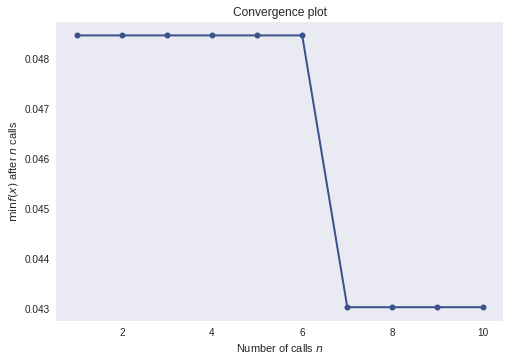

In [21]:
from skopt.plots import plot_convergence
plot_convergence(res_gp)

In [22]:
print("Best parameters: \
\nbest_hidden_layers = {} \
\nbest_initial_nodes = {} \
\nbest_dropout = {} \
\nbest_learning_rate = {}".format(res_gp.x[0],
                                 res_gp.x[1],
                                 res_gp.x[2],
                                 res_gp.x[3]))


Best parameters: 
best_hidden_layers = 3 
best_initial_nodes = 57 
best_dropout = 0.0343238878387 
best_learning_rate = 0.0361678153257
